In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 2060
Using device: cuda


### YoloV1 Network

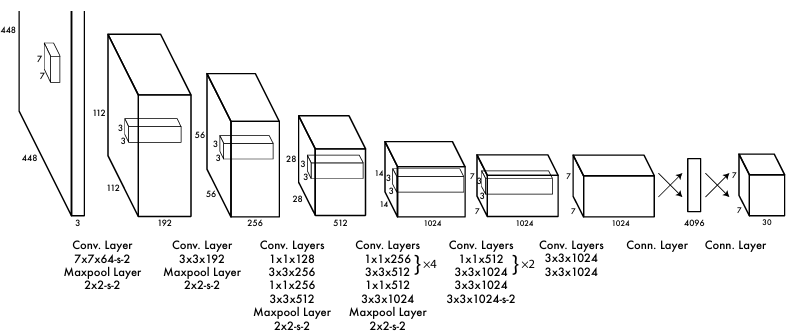

In [2]:
from torch import nn

In [ ]:
architecture_configg = [
    [7, 64, 2, 3],
    "M",
    [3, 192, 1, 1],
    "M",
    [1, 128, 1, 0],
    [3, 256, 1, 1],
    [1, 256, 1, 0],
    [3, 512, 1, 1],
    "M",
    [1, 256, 1, 0],
    [3, 512, 1, 1],
    [1, 256, 1, 0],
    [3, 512, 1, 1],
    [1, 256, 1, 0],
    [3, 512, 1, 1],
    [1, 256, 1, 0],
    [3, 512, 1, 1],

    [1, 512, 1, 0],
    [3, 1024, 1, 1],
    "M",
    [1, 512, 1, 0], 
    [3, 1024, 1, 1],
    [1, 512, 1, 0], 
    [3, 1024, 1, 1],
    [3, 1024, 1, 1],
    [3, 1024, 2, 1],
    [3, 1024, 1, 1],
    [3, 1024, 1, 1]
]

In [33]:
class MiniBlock(nn.Module):
    def __init__(self,in_channels,num_filters,kernel_size,stride,padding):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, num_filters, bias=False, kernel_size=kernel_size, stride=stride,padding=padding)
        self.batchnorm = nn.BatchNorm2d(num_filters)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x=self.conv(x)
        x=self.batchnorm(x)
        x=self.leakyrelu(x)
        return x
        
class YoloV1(nn.Module):
    def __init__(self):
        super().__init__()
        
        layers = []
        
        in_filters=3
        for i,item in enumerate(architecture_configg):
            
            if type(item) == list:
            
                kernel=item[0]
                num_filters=item[1]
                stride=item[2]
                padding=item[3]
                
                layers.append(MiniBlock(in_filters,num_filters,kernel,stride,padding))
                in_filters=num_filters
                
            else:
                layers.append(nn.MaxPool2d(2, stride=2))
                

        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=7*7*1024, out_features=4096))
        layers.append(nn.LeakyReLU(0.1))
        layers.append(nn.Linear(in_features=4096, out_features=7*7*30))
            
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

In [34]:
model = YoloV1()

In [35]:
model.to(device);

In [36]:
from torchsummary import summary
summary(model, (3, 448, 448))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           9,408
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         LeakyReLU-3         [-1, 64, 224, 224]               0
         MiniBlock-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 192, 112, 112]         110,592
       BatchNorm2d-7        [-1, 192, 112, 112]             384
         LeakyReLU-8        [-1, 192, 112, 112]               0
         MiniBlock-9        [-1, 192, 112, 112]               0
        MaxPool2d-10          [-1, 192, 56, 56]               0
           Conv2d-11          [-1, 128, 56, 56]          24,576
      BatchNorm2d-12          [-1, 128, 56, 56]             256
        LeakyReLU-13          [-1, 128, 56, 56]               0
        MiniBlock-14          [-1, 128,